In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Data Sourcing

In [2]:
from weather import Weather
weather = Weather().get_data()
weather = Weather().clean_data(weather)

from expeds import Expeds
exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

root_dir = os.path.abspath('')
xls_path = os.path.join(root_dir, 'data\\exped_time_2.xls')
time = pd.read_excel(xls_path)

# Column Dropping

In [29]:
exp_to_drop = ['year','season','route1','route2','nation','leaders','sponsor','success1','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date','term_reason', 'summit_days',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_hired','hired_deaths']

exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')

# Merging

In [3]:
df = time[['peakid', 'smtdate', 'smtmembers']]
df = df[df['peakid']=='EVER']
df.drop(['peakid'], axis=1, inplace=True)
df['smtdate'] = pd.to_datetime(df.smtdate, errors = 'coerce')

# Group by date

In [4]:
df_ts = df.dropna()
df_ts.set_index('smtdate', inplace=True)
df_ts = df_ts.groupby(['smtdate']).sum(['smtmembers'])
df_ts = df_ts.asfreq('d')
df_ts = df_ts.fillna(0)
df_ts = df_ts[df_ts.index >= '1960']
df_ts.head()

,smtmembers
smtdate,
1960-01-01,0.0
1960-01-02,0.0
1960-01-03,0.0
1960-01-04,0.0
1960-01-05,0.0


In [83]:
df_ts.shape

(756, 1)

# Visualization

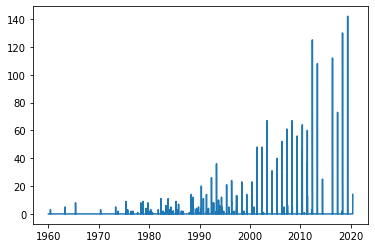

In [116]:
plt.plot(df_ts)
plt.show()

# Time Series - Analysis

In [117]:
from statsmodels.tsa.stattools import adfuller

res = adfuller(df_ts)
print('p_val: ', res[1])

# The p-value should be less than 0.05 to have a 95% confidence in the stationarity.

p_val:  0.0


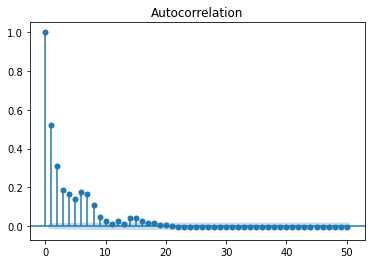

In [118]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_ts, lags=50);

AR order (p) can be found by investigating the plot plot_pacf. 

Select the order of AR term equal to the number of consecutive lag crossing the significance limit in the PACF plot.

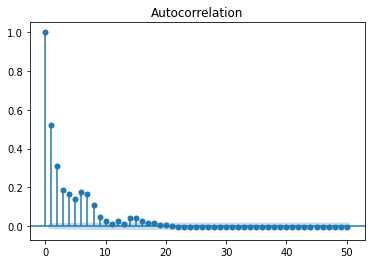

In [119]:
plot_acf(df_ts, lags=50);

MA order (q) can be found by looking at the plot_acf. 

The order of MA term equals the number of consecutive lag crossing the significance limit in the PACF plot.

# ARIMA

## Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

p,d,q = 3,0,3

arima = ARIMA(df_ts, order=(p,d,q))
arima = arima.fit()
arima.summary()

## Evaluation

In [ ]:
# Actual vs Fitted
arima.plot_predict(dynamic= False);

### Out-of-sample forecasts (real "future")

In [ ]:
train = df_ts[:'2017']
test = df_ts['2018':]

arima = ARIMA(train, order=(p,d,q))
arima = arima.fit()
arima.summary()

In [ ]:
ypred = arima.forecast(len(test))[0]

In [ ]:
preds = pd.DataFrame(index=test.index, data=ypred)
ts.plot()
plt.plot(preds, color = 'r', label= 'forecast')
plt.legend()
plt.show()

## Auto ARIMA

In [120]:
import pmdarima as pm

model = pm.auto_arima(df_ts, 
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=106787.697, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=113935.222, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=106851.113, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=108722.032, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=106645.022, Time=1.80 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=106791.746, Time=0.38 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=106730.583, Time=3.41 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=106645.731, Time=2.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=106758.667, Time=1.26 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=106791.362, Time=0.55 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=106575.877, Time=5.70 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=106525.441, Time=7.02 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=106668.512, Time=0.92 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=106512.709, Time=8.77 sec
 ARIM

KeyboardInterrupt: 

In [107]:
train = df_ts[:'2017']
test = df_ts['2018':]

ypred = model.predict(len(test))[0]

preds = pd.DataFrame(index=test.index, data=ypred)
df_ts.plot()
plt.plot(preds, color = 'r', label= 'forecast')
plt.legend()
plt.show()

ValueError: DataFrame constructor not properly called!

# SARIMA

In [156]:
df_ts['cumul_summiters'] = df_ts['smtmembers'].cumsum()

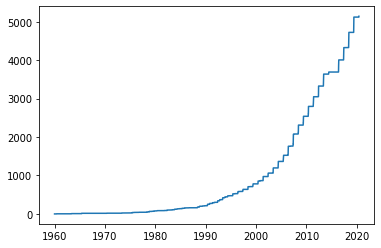

In [157]:
plt.plot(df_ts.cumul_summiters)

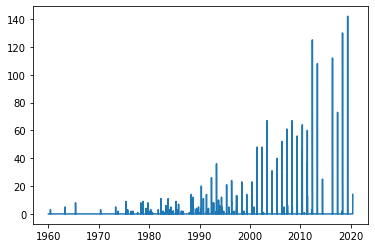

In [160]:
plt.plot(df_ts.smtmembers)

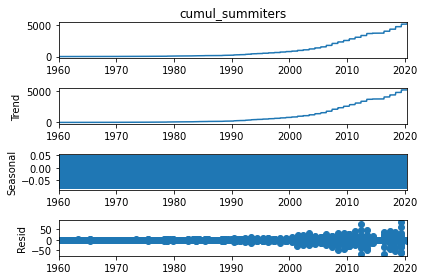

In [158]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts = df_ts.cumul_summiters

result_add = seasonal_decompose(ts, model='additive')
result_add.plot();

In [161]:
import pmdarima as pm

train = ts[:'2017']
test = ts['2018':]

model = pm.auto_arima(train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',
                      max_p=2, 
                      max_q=2,
                      m=12,
                      d=0,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=181110.035, Time=12.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=182247.231, Time=0.83 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=111623.216, Time=20.51 sec


KeyboardInterrupt: 

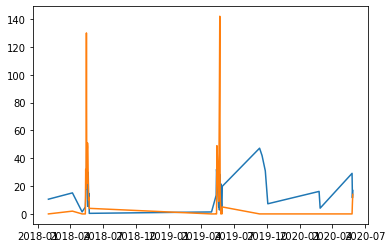

In [130]:
ypred = model.predict(len(test))

plt.plot(pd.DataFrame(data = ypred, index = test.index, columns=['ypred']))
plt.plot(test)
plt.show()

# RNN

In [131]:
time = pd.read_excel(xls_path)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()


In [ ]:
import numpy as np
import math

def get_sample(data, length, temporal_horizon):

    temporal_horizon = temporal_horizon - 1
    last_possible = len(data) - temporal_horizon - length
    random_start = np.random.randint(0, last_possible)
    
    y_sample = data.loc[random_start+length+temporal_horizon, 'pm2.5']
    
    while math.isnan(y_sample):
        random_start = random_start + 1
        y_sample = data.loc[random_start+length+temporal_horizon, 'pm2.5']
        
    X_sample = data.loc[random_start: random_start+length, ['DEWP', 'TEMP', 'Iws', 'Is', 'Ir']] 
    
    return X_sample, y_sample

# Exploration

In [134]:
df_ts['month'] = df_ts.index.month
df_ts['year'] = df_ts.index.year

In [142]:
df_month = df_ts.groupby(pd.Grouper(freq="M")).agg({'smtmembers': 'sum',
                                                   'month' : 'mean'})

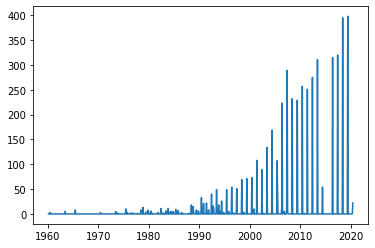

In [143]:
plt.plot(df_month.smtmembers)

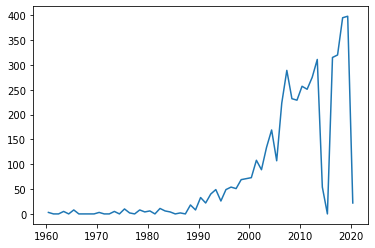

In [144]:
df_may = df_month[df_month['month']==5]
plt.plot(df_may.smtmembers)

In [150]:
train = df_may.loc[:'2016', 'smtmembers']
test = df_may.loc['2017':, 'smtmembers']

model = pm.auto_arima(train, 
                      start_p=0, 
                      start_q=0,
                      test='adf',
                      max_p=3, 
                      max_q=3,
                      m=1,
                      d=0,
                      seasonal=True,
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=684.726, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=632.317, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=636.461, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=704.454, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=634.013, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=627.856, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=622.581, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=602.692, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=605.813, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=603.317, Time=0.14 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=612.644, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=601.868, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=623.719, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=604.809, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=602.3

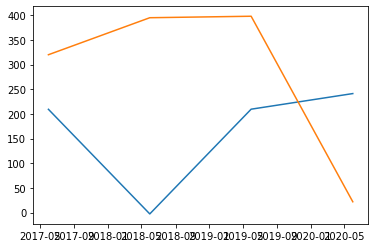

In [151]:
ypred = model.predict(len(test))

plt.plot(pd.DataFrame(data = ypred, index = test.index, columns=['ypred']))
plt.plot(test)
plt.show()

# Weather Evoluation

In [6]:
weather.set_index('date_time', inplace=True)

In [9]:
weather['month'] = weather.index.month
weather['year'] = weather.index.year

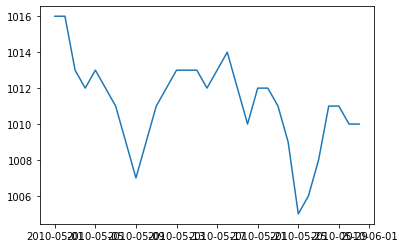

In [15]:
plt.plot(weather['2010-05'].pressure)

In [57]:
weather['rolling_pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['rolling_pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['rolling_pressure_futur'] - weather['rolling_pressure_past']

In [38]:
weather.loc[:,'pressure']

date_time
2010-01-01    1023
2010-01-02    1023
2010-01-03    1019
2010-01-04    1015
2010-01-05    1017
              ... 
2020-10-28    1018
2020-10-29    1020
2020-10-30    1020
2020-10-31    1020
2020-11-01    1020
Name: pressure, Length: 3958, dtype: int32

In [39]:
weather.loc[:,'pressure'].shift(-2).rolling(window=2).mean()

date_time
2010-01-01       NaN
2010-01-02    1017.0
2010-01-03    1016.0
2010-01-04    1017.5
2010-01-05    1019.0
               ...  
2020-10-28    1020.0
2020-10-29    1020.0
2020-10-30    1020.0
2020-10-31       NaN
2020-11-01       NaN
Name: pressure, Length: 3958, dtype: float64